In [1]:
import sys

import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr
from scipy import interpolate
from numpy import ma
from scipy import stats
import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing

import scipy as sp
import pandas as pd

import time

from copy import copy 

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

import matplotlib.colors as mcolors

import glob
import dask
import dask.bag as db

from scipy import interpolate

import statsmodels.stats.multitest as multitest

from matplotlib.gridspec import GridSpec
from cartopy.crs import EqualEarth, PlateCarree

import calendar

In [6]:
data_in_path = '/glade/u/home/zcleveland/scratch/ERA5/dsw/' # path to subsetted data
sub_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/subsetting/' # path to subsetting scripts
plot_script_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/scripts/plotting/' # path to plotting scripts
fig_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/' # path to generated figures
temp_scratch_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/temp/' # path to temp directory in scratch

In [3]:
# variable list to choose
var_list = [
    # 'lsp',  # large scale precipitation (m of water) - accumu
    # 'cp',  # convective precipitation (m of water) - accumu
    'tp',  # total precipitation (m of water) - accumu -- DERIVED
    'sd',  # snow depth  (m of water equivalent) - instan
    'msl',  # mean sea level pressure (Pa) - instan
    'tcc',  # total cloud cover (0-1) - instan
    'stl1',  # soil temp layer 1 (K) - instan
    'stl2',  # soil temp layer 2 (K) - instan
    'stl3',  # soil temp layer 3 (K) - instan
    'stl4',  # soil temp layer 4 (K) - instan
    'swvl1',  # soil volume water content layer 1 (m^3 m^-3) - instan
    'swvl2',  # soil volume water content layer 2 (m^3 m^-3) - instan
    'swvl3',  # soil volume water content layer 3 (m^3 m^-3) - instan
    'swvl4',  # soil volume water content layer 4 (m^3 m^-3) - instan
    '2t',  # 2 meter temp (K) - instan
    '2d',  # 2 meter dew point (K) - instan
    'ishf',  # instant surface heat flux (W m^-2) - instan
    'ie',  # instant moisture flux (kg m^-2 s^-1) - instan
    'sshf',  # surface sensible heat flux (J m^-2) - accumu
    'slhf',  # surface latent heat flux (J m^-2) - accumu
    'ssr',  # surface net solar radiation (J m^-2) - accumu
    'str',  # surface net thermal radiation (J m^-2) - accumu
    'sro',  # surface runoff (m) - accumu
    'sf',  # total snowfall (m of water equivalent) - accumu
    # 'cape',  # convective available potential energy (J kg^-1) - instan
    # 'tcw',  # total column water (kg m^-2) - sfc (sum total of solid, liquid, and vapor in a column)
]

In [4]:
# set time array to loop through
years = np.arange(1980,2020)
months = np.arange(1,13)

In [5]:
# a function to take in 2 variables and calculate the correlation between them
def correlation_plot(var1=['tp',678],     # first variable and months in a list (e.g. 678 = JJA)
                     var2=['swvl1',345],  # second variable and months in a list (e.g. 345 = MAM)
                     start_year=1980,     # year to start correlations
                     end_year=1989,       # year to end correlations
                    ):

    var1_list = [] # initialize first variable list
    var2_list = [] # initialize second variable list

    var1_range = [int(m1) for m1 in str(var1[1])] # turn var1 integer into list (e.g. 678 -> [6,7,8]
    var2_range = [int(m2) for m2 in str(var2[1])] # turn var2 integer into list (e.g. 345 -> [3,4,5]

    for year in range(start_year, end_year+1): # loop through years

        # open datasets for each variable
        var1_temp = xr.open_dataset(f'{data_in_path}{year}/{var1[0]}_{year}01_{year}12_dsw.nc')
        var2_temp = xr.open_dataset(f'{data_in_path}{year}/{var2[0]}_{year}01_{year}12_dsw.nc')

        # pull out actual variable name in the dataset since they can be different names/capitalized
        var1x = [v1 for v1 in var1_temp.data_vars.keys() if f'{var1[0].upper()}' in v1][0]
        var2x = [v2 for v2 in var2_temp.data_vars.keys() if f'{var2[0].upper()}' in v2][0]

        # pull out variables and keep them a dataset
        var1_temp = var1_temp[f'{var1x}'].to_dataset()
        var2_temp = var2_temp[f'{var2x}'].to_dataset()

        # compute sum or mean depending on variable (e.g. sum 'tp' and mean 'swvl1')
        # over the range of months and store in var_lists
        if 'AVG' in var1x: # var1
            var1_list.append(var1_temp.isel(time=var1_temp['time.month'].isin(var1_range)).mean(dim='time'))
        else:
            var1_list.append(var1_temp.isel(time=var1_temp['time.month'].isin(var1_range)).sum(dim='time'))

        if 'AVG' in var2x: # var2
            var2_list.append(var2_temp.isel(time=var2_temp['time.month'].isin(var2_range)).mean(dim='time'))
        else:
            var2_list.append(var2_temp.isel(time=var2_temp['time.month'].isin(var2_range)).sum(dim='time'))

    # merge var_lists into 1 output and compute correlation between the two
    var1_out = xr.concat(var1_list, dim='time')
    var2_out = xr.concat(var2_list, dim='time')
    var_corr = xr.corr(var1_out[f'{var1x}'], var2_out[f'{var2x}'], dim='time')


    # plot the results
    projection = ccrs.PlateCarree()    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))
    
    # plot the data using contourf
    cf = plt.contourf(var_corr.longitude, var_corr.latitude,
                      var_corr, levels=20,
                      cmap='RdBu_r', vmin=-1, vmax=1)    
    
    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    var1_months = ''.join([calendar.month_name[m][0] for m in var1_range])
    var2_months = ''.join([calendar.month_name[m][0] for m in var2_range])
    
    plt.title(f'Correlation between {var1[0].upper()}-{var1_months} and {var2[0].upper()}-{var2_months}')    
    plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient')
    plt.show()
    plt.close()


In [ ]:
correlation_plot(['2t',345], ['tp',678], 1980, 2019)

In [ ]:
for var in var_list:
    correlation_plot([var,345], ['tp',678], 1980, 2019)

In [4]:
def plot_onset_correlation(var=['swvl1',345]):

    # create list of months over which to average
    var_mons = [int(m) for m in str(var[1])] # turn var integer into list (e.g. 678 -> [6,7,8])

    # open datasets
    # onset
    onset_ds = xr.open_dataset(f'{data_in_path}NAM_onset.nc')
    onset_ds['year'] = onset_ds['year'].dt.year # convert to only year.  e.g. 2012-01-01 -> 2012
    onset_da = onset_ds['date']
    onset_data = onset_da.dt.dayofyear.astype('float32')
    # in_var
    var_files = glob.glob(f'{data_in_path}*/{var[0]}*.nc')
    var_ds = xr.open_mfdataset(var_files)

    # pull out actual variable name in the dataset since they can be different names/capitalized
    var_name = [v for v in var_ds.data_vars.keys() if f'{var[0].upper()}' in v][0]
    var_da = var_ds[var_name]

    # get data from var
    if 'AVG' in var_name:
        mon_mean = var_da.resample(time='1M').mean()
        var_mon_mean = mon_mean.sel(time=mon_mean['time.month'].isin(var_mons))
        var_data = var_mon_mean.groupby('time.year').mean(dim='time')
    else:
        mon_sum = var_da.resample(time='1M').sum()
        var_mon_sum = mon_sum.sel(time=mon_sum['time.month'].isin(var_mons))
        var_data = var_mon_sum.groupby('time.year').sum(dim='time')

    # calculate correlation
    var_corr = xr.corr(onset_data, var_data, dim='year')

    # plot the results
    projection = ccrs.PlateCarree()    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=projection))
    
    # plot the data using contourf
    cf = plt.contourf(var_corr.longitude, var_corr.latitude,
                      var_corr, levels=50,
                      cmap='RdBu_r', vmin=-1, vmax=1)    
    
    # add coastlines, state borders, and other features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES)

    # make string for month letters from var_range (e.g. [6,7,8] -> 'JJA')
    var_months = ''.join([calendar.month_name[m][0] for m in var_mons])
    
    plt.title(f'Correlation Between Start Date of the Monsoon and {var[0].upper()} ({var_months})')    
    plt.colorbar(cf, ax=ax, label='Pearson Correlation Coefficient')
    plt.savefig(f'{fig_out_path}correlations/corr_{var[0]}_onset_{var_months}.png', dpi=300)
    plt.show()
    plt.close()


In [ ]:
plot_onset_correlation(['tp', 345])

In [ ]:
for var in var_list:
    plot_onset_correlation([var, 345])

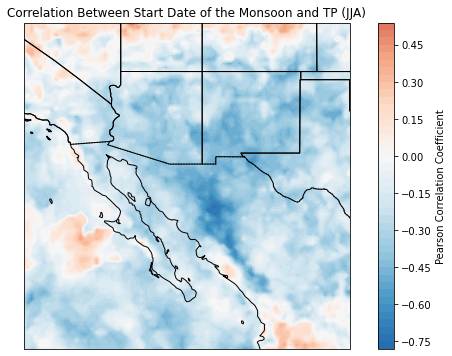

In [8]:
# summertime precip totals and onset date
plot_onset_correlation(['tp', 678])